In [1]:
%run load-clean-select.ipynb

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


Morphology was measured for 610.0 cells.

The numbers of cells and nuclei correspond to each other.

The are no duplicated column names: True
The are no duplicated column names: True
Cytoplasm measurements were taken for 610 cells.

The are no duplicated column names: True
Read biomarkers normalised by to min gain
Biomarkers were measured for 610 cells.

The are no duplicated column names: True

Full dataset has shape: (610, 484)
Initial shape is: (610, 484)
Features with zero variance:
 Index(['centerZ_cell', 'eulernumber_cell', 'children_cytoplasm_count_cell',
       'loc_centermassintensityZ_wga', 'loc_centerZ_cell',
       'loc_maxintensityZ_wga', 'centerZ_nucl', 'eulernumber_nucl',
       'children_cells_count', 'children_cytoplasm_count_nucl',
       'loc_centermassintensityZ_dapi', 'loc_centerZ_nucl',
       'loc_maxintensityZ_dapi', 'centerZ_cyto',
       'loc_centermassintensityZ_ker', 'loc_centermassintensityZ_vim',
       'loc_centerZ', 'loc_maxintensityZ_ker', 'loc_maxinten

###### Undersample images

In [ ]:
np.random.seed(42)
image_id = np.random.choice(measurements_red[measurements_red.stiffness == '2.0'].image.unique(), 7)
print(image_id)
measurements_red[measurements_red.image.isin(image_id)].shape

In [ ]:
measurements_b = measurements_red.drop(measurements_red[measurements_red.image.isin(image_id)
                                                         ].index
                                        ).reset_index(drop=True)
measurements_b.shape

###### SMOTE

In [ ]:
measurements = proc.smote(measurements[feature_cols], measurements.stiffness)

# Which dataset?

In [13]:
# The full dataset
# df = measurements
# Dataset without clusters at 64kPa
# df = measurements_red
# Dataset without 0.5kPa, 8kPa and clusters at 64kPa
df = measurements_5
# Dataset without 0.5kPa, 8kPa and clusters at 64kPa with balanced classes
# df = measurements_b

# Some functions

In [17]:
# Prepare a vector of colours mapped to the 'stiffness' column
def create_palette(df, by='stiffness', show=False):
    if by == 'stiffness':
        n_levels = df.stiffness.unique().size
        palette = dict(zip(df.stiffness.unique(), sns.color_palette("Set3", n_levels)))
        row_colors = df.stiffness.map(palette)
    elif by == 'cluster':
        n_levels = df.cluster.unique().size
        if n_levels == 2:
            palette = {1 : sns.color_palette("PRGn", 20)[15], 2 : sns.color_palette("PRGn", 20)[4]}
        else:
            palette = dict(zip(range(n_levels), sns.color_palette("PRGn", n_levels)))
        row_colors = df.cluster.map(palette)
    elif by == 'biom':
        palette = {df.biom.unique()[0] : sns.color_palette("RdBu", 10)[1],
                   df.biom.unique()[1] : sns.color_palette("RdBu", 10)[8]}
        row_colors = df.biom.map(palette)
        
    if show:
#         print(list(palette.keys()))
        sns.palplot(palette.values());
    
    return row_colors, palette
# plt.savefig('../results/My palette.png', bbox_inches='tight', dpi=300);

In [18]:
def plot_corr(correlations, mask=False, threshold=0.9, annot=False):
    if mask:
        mask = np.zeros_like(correlations)
        mask[abs(correlations) < threshold] = 1

    plt.rcParams['figure.figsize'] = (10, 10)

    sns.heatmap(correlations, 
                mask=mask, annot=annot,
                vmin=-1, vmax=1,
                cmap=sns.color_palette("RdBu_r", 100));

# Summary

In [ ]:
df.head(3)

In [ ]:
list(df.columns)

In [ ]:
df.info()

## Cells per stiffness value

In [3]:
n = df.groupby('stiffness').size().values
nstiff = len(df.stiffness.unique())

groups = np.zeros(df.shape[0], np.int)
j = 0
for i in range(nstiff):
    groups[j : j + n[i]] = i
    j = j + n[i]
n

array([50, 50, 50, 55, 50])

In [ ]:
plt.rcParams['figure.figsize'] = (0.5, 3)

sns.heatmap(pd.DataFrame(groups, columns=['n']), 
            cmap=sns.color_palette("Set3", nstiff),
            cbar_kws={"aspect": 5}, cbar=False,
            xticklabels=False, yticklabels=False); 
plt.savefig('../results/Substrates groups cbar.png', bbox_inches='tight', dpi=300);

## Cells per image (density)

In [22]:
cell_numbers = df.groupby(['stiffness', 'image'], as_index=False)[['object']].count()
cell_numbers.groupby('stiffness').mean()

,object
stiffness,
0.2,8.300000
2.0,11.571429
16.0,8.083333
32.0,6.111111
64.0,7.000000


In [ ]:
plt.rcParams['figure.figsize'] = (6, 4)
sns.barplot(x="stiffness", y="object",
            data=cell_numbers, ci='sd', 
            palette=sns.color_palette("Set2", 7));
plt.xlabel("Stiffness")
plt.ylabel("Count")
plt.title("Number of Cells per Image")
plt.savefig('../results/Cells per image.png', bbox_inches='tight', dpi=300);

## Images per stiffness

In [24]:
df.groupby('stiffness').image.nunique()

stiffness
0.2     10
2.0     14
16.0    12
32.0     9
64.0     9
Name: image, dtype: int64

## Groups of features (general)

In [ ]:
col_names = (('area_cell', 'maxintdisplacement_wga_nucl'),
             ('integratedintensityedge_ker', 'log_cvratio'))

In [ ]:
groups = np.zeros(len(feature_cols), np.int)
groups.shape

In [ ]:
j = 0
for i in range(len(col_names)):
    n = measurements.loc[:, col_names[i][0] : col_names[i][1]].columns.size
    groups[j : j + n] = i
    j = j + n

In [ ]:
plt.rcParams['figure.figsize'] = (20, 0.5)
sns.heatmap(pd.DataFrame(groups, columns=['n']).T, 
            cmap=sns.color_palette("Set3", 4), 
            cbar=False,
            xticklabels=False, yticklabels=False); 
plt.savefig('../results/All features groups cbar.png', bbox_inches='tight', dpi=300);

## Groups of features (geometric)

In [ ]:
geom_cols

In [ ]:
col_names = (('area_cell', 'zernike_9_9_cell'),
             #('integratedintensityedge_wga_cell', 'minintensity_wga_cell'), 
             ('neighbors_anglebetweenneighbors_3','neighbors_secondclosestdistance_3'), 
             #('angularsecondmoment_wga_00_cell', 'infomeas2_wga_00_cell'),
             ('area_nucl', 'zernike_9_9_nucl'),
             #('integratedintensityedge_dapi', 'stdintensity_wga_nucl'),
             ('neighbors_anglebetweenneighbors_20', 'neighbors_secondclosestdistance_20'),
             #('angularsecondmoment_dapi_00', 'sumentropy_dapi_01'),
             ('eulernumber_cyto', 'zernike_9_5_cyto'),
             ('fartherstpoint_cell', 'ncr'))

In [ ]:
groups = np.zeros(len(geom_cols), np.int)

j = 0
for i in range(len(col_names)):
    n = measurements.loc[:, col_names[i][0] : col_names[i][1]].columns.size
    groups[j : j + n] = i
    j = j + n

In [ ]:
plt.rcParams['figure.figsize'] = (20, 0.5)
sns.heatmap(pd.DataFrame(groups, columns=['n']).T, 
            cmap=sns.color_palette("Set3", 6),
            cbar=False,
            xticklabels=False, yticklabels=False); 
plt.savefig('../results/Geom features groups cbar.png', bbox_inches='tight', dpi=300);

## Descriptive statistics

In [ ]:
measurements.describe()

In [ ]:
measurements.describe(include=['object'])

# Correlations

Plate-layout-effect and batch-effect corrections

> To add heat maps of the correlations between all of wells within an experiment.

## Correlations between replicates

> Calculate the correlations between replicates.

In [ ]:
plot_corr(measurements.corr(method='spearman'))

In [ ]:
from snf import datasets
digits = datasets.load_digits()
df = pd.DataFrame(digits.data[0])
sns.heatmap(df.corr(), vmin=-1, vmax=1,
            cmap=sns.color_palette("RdBu_r", 100));

In [ ]:
plot_corr(measurements.corr(method='spearman').loc[cell_cols, biom_cols], mask=True, threshold=0.5)

## Correlation with stiffness

In [ ]:
# Create numeric stiffness variable and define feature columns
df['stiffness_num'] = pd.to_numeric(df.stiffness)
df['stiffness_log2'] = np.log2(df.stiffness_num)

### Pearson's correlation

In [ ]:
p_corr = df[geom_cols].corrwith(pd.to_numeric(df.stiffness))
p_corr.abs().sort_values(ascending=False).head(10)

In [ ]:
plt.rcParams['figure.figsize'] = (15, 2)

sns.heatmap(pd.DataFrame(p_corr, columns=['Pearsons']).T, 
            cmap=sns.color_palette("RdBu_r", 100), 
            vmin=-1, vmax=1);

#plt.savefig('../results/Corr with Stiffness SMOTE.png', bbox_inches='tight', dpi=300);

### Spearman's correlation

In [ ]:
s_corr = df[geom_cols].corrwith(pd.to_numeric(df.stiffness), method='spearman')
s_corr.abs().sort_values(ascending=False).head(10)

In [ ]:
s_corr[['solidity_cell', 'perimeter_cell', 'formfactor_cell']]

In [ ]:
plt.rcParams['figure.figsize'] = (2, 4)

sns.lmplot(x='stiffness_num', y='formfactor_cell', data=df, order=2);

# plt.ylim([0, 13]);
plt.xlabel("Stiffness, kPa");
plt.ylabel("Cell circularity, a.u.");
plt.savefig('../results/corr circularity.png', bbox_inches='tight', dpi=300);

In [ ]:
plt.rcParams['figure.figsize'] = (6, 4)
sns.boxplot(x='stiffness', y='perimeter_cell', data=df, showfliers=False);

In [ ]:
plt.rcParams['figure.figsize'] = (15, 2)

sns.heatmap(pd.DataFrame(s_corr, columns=['Spearmans']).T, 
            cmap=sns.color_palette("RdBu_r", 100), 
            vmin=-1, vmax=1);
#plt.savefig('../results/Corr with Stiffness.png', bbox_inches='tight', dpi=300);

### Difference between Spearman's and Pearson's

In [ ]:
(s_corr - p_corr).plot(kind='bar', figsize=(15, 5));
#plt.savefig('../results/Spearman-Pearson SMOTE.png', bbox_inches='tight', dpi=300);

### Univariate modelling

In [ ]:
sns.lmplot(x='stiffness_num', y='ncr', data=df, order=1);

In [ ]:
df['stiffsquared'] = df.stiffness_num**2
df['stiffcubed'] = df.stiffness_num**3

In [ ]:
# X = df.stiffness_num.values.reshape(-1, 1)
X = df[['stiffness_num']]
y = df.ncr

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X, y)
model.score(X, y)

In [ ]:
df[['stiffness_num']].corrwith(df.ncr)

In [ ]:
import statsmodels.formula.api as sm

model1 = sm.ols(formula="ncr ~ stiffness_num", data=df).fit()
model2 = sm.ols(formula="ncr ~ stiffness_num + stiffsquared", data=df).fit()
model3 = sm.ols(formula="ncr ~ stiffness_num + stiffsquared + stiffcubed", data=df).fit()

model1.summary()

# print result.rsquared, result.rsquared_adj

In [ ]:
model2.summary()

In [ ]:
model3.summary()

In [ ]:
import statsmodels.api as sm

model = sm.OLS(X, y).fit()
model.summary()
# print result.rsquared, result.rsquared_adj

# Visualise features 

In [ ]:
X = df[feature_cols]
print(X.shape)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

df_scaled = pd.concat([df[meta_cols], 
                       pd.DataFrame(X_scaled, columns=feature_cols)], 
                      axis=1)

## All features

In [ ]:
plt.rcParams['figure.figsize'] = (15, 4)

sns.heatmap(X_scaled,
            vmin = -2.5, vmax = 2.5,
            cmap=sns.color_palette("RdBu_r", 100),
            cbar_kws={"aspect": 20},
            xticklabels=False, yticklabels=False);

plt.savefig('../results/All features heatmap.png', bbox_inches='tight', dpi=300);

## Aggregated values

In [ ]:
sns.set(rc={'figure.figsize':(15, 3)})

mean_per_stiffness = df_scaled.groupby('stiffness')[feature_cols].mean()

sns.heatmap(mean_per_stiffness, 
            vmin = -1, vmax = 1,
            cmap=sns.color_palette("PRGn", 100), 
            cbar_kws={"aspect": 5},
            xticklabels=False, yticklabels=True);

plt.savefig('../results/Aggregated features heatmap.png', bbox_inches='tight', dpi=300);

## Morphological features across stiffness values

In [ ]:
row_colors, palette = create_palette(df)

In [ ]:
plt.rcParams['figure.figsize'] = (5, 3)

for var in geom_cols:
    plt.figure()
    sns.boxplot(x='stiffness', y=var, data=df, palette=palette);
#     plt.savefig('../results/Geometric features/' + var + '.png', bbox_inches='tight', dpi=300);

In [ ]:
sns.boxplot(x='stiffness', y='ncr', data=measurements_red, palette=palette);

## PCA on morphological features

In [15]:
# Feature map
cols = biom_cols
X = df[cols]

# Standartise the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Number of components requred to describe 90% variance
pca = PCA(n_components=0.9)

# Apply PCA to the scaled feature matrix
X_reduced = pca.fit_transform(X_scaled)

pc_cols = [('pc_' + str(i)) for i in range(1, X_reduced.shape[1] + 1)]
pc_df = pd.concat([df.loc[:, ['stiffness']],
                  pd.DataFrame(data = X_reduced, columns = pc_cols)], 
                  axis=1)

print("The first {} components explain 90% of variance.\n".format(pca.n_components_ ))

print("Explained variance:\n", pca.explained_variance_ratio_)

X.shape, pca.components_.shape, X_reduced.shape, pc_df.shape

The first 16 components explain 90% of variance.

Explained variance:
 [0.21117774 0.1676414  0.13299338 0.06635325 0.05673176 0.05006785
 0.03380618 0.03023089 0.02679327 0.02441459 0.02387434 0.0214958
 0.01707703 0.01472345 0.01349656 0.01190515]


((460, 61), (16, 61), (460, 16), (460, 17))

In [ ]:
plt.plot(pca.explained_variance_ratio_);

#plt.savefig('../results/Explained variance ratio.png', bbox_inches='tight', dpi=300);

In [ ]:
pc_df[pc_cols].T.plot(legend=False);

#plt.savefig('../results/Principal components.png', bbox_inches='tight', dpi=300);

In [ ]:
plt.plot(pca.components_[0]);

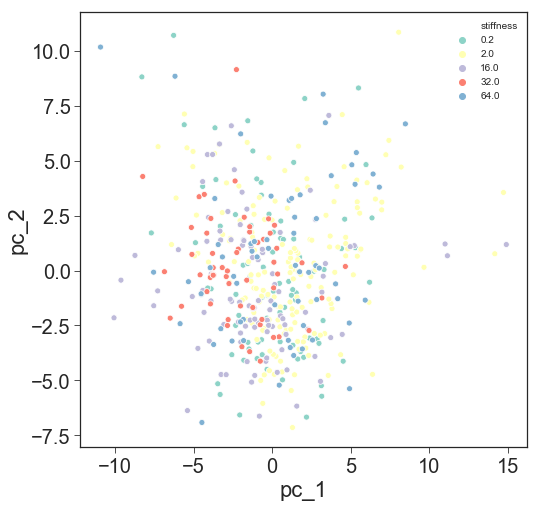

In [19]:
plt.rc("figure", figsize=(8, 8))

row_colors, palette = create_palette(df, by='stiffness')

sns.scatterplot(x='pc_1', y='pc_2', data=pc_df, 
                hue='stiffness', palette=palette);

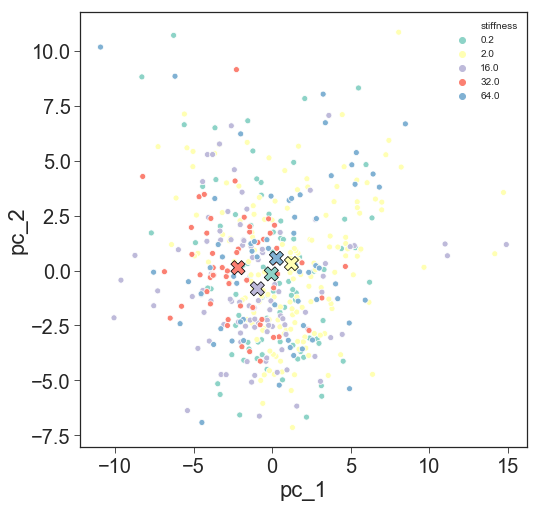

In [20]:
centroids = pc_df.groupby('stiffness')[['pc_1', 'pc_2']].mean().reset_index()

sns.scatterplot(x='pc_1', y='pc_2', data=pc_df, 
                hue='stiffness', palette=palette);
sns.scatterplot(x="pc_1", y="pc_2", data=centroids, 
                hue='stiffness', palette=palette, 
                s=200, marker='X', edgecolor='black', 
                legend=None);

In [21]:
first_component = zip(cols, pca.components_[0])

for col, weight in first_component:
    if abs(weight) > 0.2:
        print(col, weight)

meanintensity_ker 0.20839213568950485
stdintensity_ker 0.2262213882485575
stdintensity_vim 0.20035221168396028
contrast_ker_00 0.20381370969060375
contrast_ker_01 0.20557167319530117
contrast_ker_02 0.20407513508451014
contrast_ker_03 0.20079222462404592


___
**_Below are some random bits and pieces of code that I wrote at some point but right now I don't consider them usefull._**

** Pairwise distances**

In [ ]:
from sklearn.metrics import pairwise_distances

D = pairwise_distances(X_scaled)

plt.imshow(D, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();

## Subpopulations

###### Changes in morphological clustering

In [ ]:
measurements.loc[(measurements.image != '63') & (measurements.image != '64'), 'cluster2'] = agg.labels_

In [ ]:
measurements.cluster2.fillna(-1, inplace=True)

In [ ]:
measurements.cluster1 = agg.labels_

In [ ]:
(measurements.cluster1 != measurements.cluster2).sum()

In [ ]:
measurements['cluster_diff'] = np.where(measurements.cluster1 != measurements.cluster2, 1, 0)

In [ ]:
measurements[measurements.cluster2 != -1].cluster_diff.sum()

In [ ]:
measurements[measurements.cluster2 != -1].groupby('stiffness').cluster_diff.sum()

In [ ]:
measurements[measurements.cluster2 == -1].cluster1.sum()

In [ ]:
measurements.loc[(measurements.cluster2 != -1) & (measurements.cluster_diff==1), ['cluster1']].sum()

In [ ]:
measurements[(measurements.cluster2 != -1) & (measurements.cluster_diff==1)].groupby('stiffness').cluster2.sum()

# OOB acccuracy with permutations

In [ ]:
from sklearn.ensemble.forest import _generate_unsampled_indices

def oob_classifier_accuracy(rf, X_train, y_train):
    """
    Compute out-of-bag (OOB) accuracy for a scikit-learn random forest
    classifier. We learned the guts of scikit's RF from the BSD licensed
    code:
    https://github.com/scikit-learn/scikit-learn/blob/a24c8b46/sklearn/ensemble/forest.py#L425
    """
    X = X_train.values
    y = y_train.values

    n_samples = len(X)
    n_classes = len(np.unique(y))
    predictions = np.zeros((n_samples, n_classes))
    for tree in rf.estimators_:
        unsampled_indices = _generate_unsampled_indices(tree.random_state, n_samples)
        tree_preds = tree.predict_proba(X[unsampled_indices, :])
        predictions[unsampled_indices] += tree_preds
    
    predicted_class_indexes = np.argmax(predictions, axis=1)
    predicted_classes = [rf.classes_[i] for i in predicted_class_indexes]

    oob_score = np.mean(y == predicted_classes)  
    return oob_score

def permutation_importances(rf, X_train, y_train, metric):
    pd.set_option('mode.chained_assignment', None)
    baseline = rf.oob_score_
    imp = []
    for col in X_train.columns:
        save = X_train[col].copy()
        X_train.loc[:, col] = np.random.permutation(X_train[col])
        m = metric(rf, X_train, y_train)
        X_train.loc[:, col] = save
        imp.append(baseline - m)
    return np.array(imp)

imp = permutation_importances(rf_clf, X_train, y_train,
                              oob_classifier_accuracy)

# Relationship between biomarkers and morphological features

## 64 kPa vs rest

In [ ]:
print("Whole dataset:", measurements.shape)
df64 = measurements[measurements.stiffness == '64.0'].copy().reset_index(drop=True)
no64 = measurements[measurements.stiffness != '64.0'].copy().reset_index(drop=True)
print("Only 64 kPa:", df64.shape)
print("Without 64 kPa:", no64.shape)

In [ ]:
df64.image.unique()

In [ ]:
palette = sns.color_palette("Set3", 7)
sns.boxplot(x=df.stiffness, y=df.meanintensity_ker, palette=palette);

In [ ]:
sns.boxplot(x=df_red.stiffness, y=df_red.meanintensity_ker, palette=palette);

In [ ]:
df64.hist(column='meanintensity_ker', bins=20, figsize=(10, 6));

In [ ]:
df64.meanintensity_ker.describe()

In [ ]:
no64.hist(column='meanintensity_ker', bins=20, figsize=(10, 6));

In [ ]:
no64.meanintensity_ker.describe()

In [ ]:
threshold = no64.meanintensity_ker.quantile(0.95)

In [ ]:
df64[df64.meanintensity_ker > threshold].groupby('image').size()

In [ ]:
(df64[df64.meanintensity_ker > threshold].groupby('image').size() / df64.groupby('image').size()).plot(kind='bar');

In [ ]:
df64[geom_cols].corrwith(df64.meanintensity_ker, method='pearson').abs().sort_values(ascending=False).head(10)

In [ ]:
p_corr = df64[geom_cols].corrwith(df64.meanintensity_ker, method='pearson')

plt.rcParams['figure.figsize'] = (15, 3)


sns.heatmap(pd.DataFrame(p_corr, columns=['Pearsons']).T, 
            cmap=sns.color_palette("RdBu_r", 100), 
            vmin=-0.5, vmax=0.5);

In [ ]:
df64['highck'] = np.where(df64.meanintensity_ker > threshold, 1, 0)
df64.highck.describe()

In [ ]:
df64[geom_cols].corrwith(df64.highck, method='spearman').abs().sort_values(ascending=False).head(10)

In [ ]:
sns.lmplot(x='meanintensity_ker', y='minferetdiameter_cell', data=df64);

In [ ]:
sns.lmplot(x='highck', y='minferetdiameter_cell', data=df64);

In [ ]:
sns.lmplot(x='meanintensity_ker', y='meanintensity_vim', data=df64);

In [ ]:
df64[['meanintensity_ker']].corrwith(df64.meanintensity_vim, method='pearson')

In [ ]:
sns.lmplot(x='meanintensity_ker', y='meanintensity_vim', data=no64);

In [ ]:
no64[['meanintensity_ker']].corrwith(no64.meanintensity_vim, method='pearson')

In [ ]:
tmp = no64.loc[no64.stiffness=='0.2', ['meanintensity_ker', 'meanintensity_vim']]
tmp[['meanintensity_ker']].corrwith(tmp.meanintensity_vim, method='spearman')

** Correlation between cytokeratin and vimentin (P/S)**
* 0.2 kPa: 0.33/0.35
* 0.5 kPa: 0.68/0.67
* 2.0 kPa: 0.3/0.36
* 8.0 kPa: 0.69/0.71
* 16.0 kPa: 0.55/0.18
* 32.0 kPa: 0.01/0.05
* 64.0 kPa: 0.62/0.61

In [ ]:
sns.lmplot(x='meanintensity_ker', y='meanintensity_vim', data=no64[no64.stiffness=='2.0']);

In [ ]:
sns.boxplot(x='image', y='meanintensity_ker', data=df64);

In [ ]:
sns.boxplot(x='image', y='meanintensity_vim', data=df64);

In [ ]:
df[df.meanintensity_ker > 0.3]

In [ ]:
df['index'] = df.index
sns.scatterplot(x=df.index, y=df.meanintensity_ker, 
                hue=np.float32(df.image), palette=sns.color_palette("Set2", 14));
plt.ylim([0, 0.7])

In [ ]:
sns.scatterplot(x=df.index, y=df.meanintensity_ker, 
                hue=np.float32(df.image), palette=sns.color_palette("Set2", 11));
plt.ylim([0, 0.7])

In [ ]:
sns.boxplot(x=df.image, y=df.meanintensity_ker);

In [ ]:
df[geom_cols].corrwith(df.meanintensity_ker, method='spearman').abs().sort_values(ascending=False).head(10)

In [ ]:
df.plot(kind='scatter', x='percenttouching_cell', y='meanintensity_ker');

In [ ]:
palette = create_palette(measurements)

In [ ]:
cols = morph_cols
# X = measurements[cols].drop(['extent_cell', 'solidity_cell'], axis=1)
X = pd.concat([measurements[cols], pd.to_numeric(measurements.stiffness)], axis=1)
y = measurements.log_cvratio

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, X_test.shape)

rf_reg = RandomForestRegressor(n_estimators=100, oob_score=True)
rf_reg.fit(X_train, y_train)

y_pred = rf_reg.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print("Testing RMSE:", rmse_test)

print("Null RMSE:", np.sqrt(mean_squared_error(y_test, y_test.apply(lambda x: np.mean(y_train)))))

feature_importance = pd.DataFrame(X.columns, columns=['feature'])
feature_importance['weight'] = rf_reg.feature_importances_
# feature_importance['weight_sd'] = np.std([tree.feature_importances_ for tree in rf_clf.estimators_], axis=0)

feature_importance.sort_values(by='weight', ascending=False, inplace=True)

threshold = feature_importance.weight.quantile(0.9)

plt.rcParams['figure.figsize'] = (15, 6)
sns.barplot(x='feature', y='weight', data=feature_importance,  color='orangered')
plt.plot([9, 9], [-0.001, feature_importance.weight.max()], linewidth=5, color='royalblue')
plt.xticks([]);
plt.xlabel("Features");
plt.ylabel("Weight");
plt.title("Feature importance");

feature_importance[feature_importance.weight > threshold]

### Undersampling

In [ ]:
measurements_under = resampling.undersample(measurements_)
X = measurements_under[feature_cols]
y = measurements_under.stiffness
 
X.shape, y.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_train.shape, X_test.shape

In [ ]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print("Testing accuraccy:", accuracy_score(y_test, y_pred))
print("Testing f-score:", f1_score(y_test, y_pred, average='weighted'))

### SMOTE

In [ ]:
measurements_.groupby('stiffness').size()

In [ ]:
X = measurements_[feature_cols]
y = measurements_.stiffness
 
X.shape, y.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_train.shape, X_test.shape

In [ ]:
X_train_sm, y_train_sm = proc.smote(X_train, y_train, as_df=False)

In [ ]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train_sm, y_train_sm)
y_pred = rfc.predict(X_test)
print("Testing accuraccy:", accuracy_score(y_test, y_pred))
print("Testing f-score:", f1_score(y_test, y_pred, average='weighted'))

In [ ]:
labels = y_test.unique().sort_values()
confusion = confusion_matrix(y_test, y_pred, labels=labels)
confusion_df = pd.DataFrame(confusion, columns=labels, index=labels)
confusion_df

In [ ]:
feature_importance = zip(feature_cols, rfc.feature_importances_)

for col, weight in feature_importance:
    if (weight > 0.02):
        print(col, weight)

## k-Means

In [ ]:
X = measurements_syn[feature_cols]
#X = measurements_syn.loc[measurements_syn.stiffness != "8.0", feature_cols]

X.shape

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
km = KMeans(n_clusters=2, random_state=1)
km.fit(X_scaled)

measurements_syn['cluster'] = km.labels_
#measurements_syn.loc[measurements_syn.stiffness != "8.0",'cluster'] = km.labels_

In [ ]:
sns.scatterplot(data=measurements_syn, x='stiffness', y='cluster', 
                palette=sns.color_palette("husl", 7), 
                alpha=0.1, s=100);

In [ ]:
pd.crosstab(measurements_syn.stiffness, 
            measurements_syn.cluster).plot(kind='bar');
plt.xlabel("Stiffness")
plt.ylabel("Count")
plt.title("Number of Cells from Each Cluster");
plt.savefig('../results/Two clusters - morph only.png', bbox_inches='tight', dpi=300);